# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - **minimum required spend** to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in **hours** since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1.  What to do

### Goal/Achievements
To combine transaction, demographic and offer data to determine **which demographic groups respond best to which offer type.**

### Way how to do

- **A machine learning model** that predicts **how much someone will spend based on demographics and offer type**. 
- **A model** that predicts **whether or not someone will respond to an offer**.
- **A set of heuristics** that determine **what offer you should send to each customer** (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### About Data

- **Once every few days**, Starbucks sends out **an offer to users of the mobile app**. An offer can be merely an advertisement for a drink or an actual offer such as a **discount** or **BOGO (buy one get one free)**. Some users might **not** receive any offer during certain weeks. 

- Every offer has a **validity period** before the offer expires.  

- **informational offers** have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, **you can assume the customer is feeling the influence of the offer for 7 days** after receiving the advertisement.

- transactional data showing user purchases **made on the app** including the **timestamp of purchase** and the **amount of money spent** on a purchase. 

- transactional data also has a record for each offer that a user receives as well as a record for **when a user actually views the offer**. There are also records for **when a user completes an offer**. 

- **someone using the app** might make a purchase through the app **without having received an offer or seen an offer**.

- **a user can receive an offer, never actually view the offer, and still complete the offer**. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, **the customer was not influenced by the offer because the customer never viewed the offer**.

- **Some demographic groups will make purchases even if they don't receive an offer**. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. **You'll want to try to assess what a certain demographic group will buy when not receiving any offers**.

### Question

- which demographic groups respond best to which offer type
> - *receive/view/complete*
> - *receive/view*
> - *receive/not view/complete*
> - *not receive/transaction*
> - *information/transaction*
- how much someone will spend based on demographics and offer type


# 2. Data Understanding

## 'portfolio' dataframe

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
portfolio = portfolio.copy()

In [5]:
portfolio['duration'] = pd.to_datetime(portfolio['duration'], format='%d').dt.day

In [6]:
portfolio.rename(columns={'id':'offer id'}, inplace=True)

In [7]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## 'profile' dataframe

In [8]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [9]:
profile = profile.copy()

In [10]:
profile['became_member_on']=profile['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


In [12]:
def generation(profile=profile):
    '''
    create 'generation' column
    imput: Profile df
    output : profile df with generation column
    '''
    bin_edges = [10,20,30,40,50,60,70,80,90,100,110,120]
    bin_names = ['10s','20s','30s','40s','50s','60s','70s','80s','90s','100s','110s']
    profile['generation'] = pd.cut(profile['age'], bin_edges, labels=bin_names)
    
    return profile

generation()

,gender,age,id,became_member_on,income,generation
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,110s
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,50s
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,110s
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,70s
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,110s
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,40s
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,60s
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,40s
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,80s


In [13]:
def loyality(profile=profile):
    
    '''
    create 'loyality' column, membership duration between latest membership - 'became_member_on'
    imput: profile df
    output: profile df with loyality column
    
    '''
    latest = profile.became_member_on.max()
    membership_duration = (latest - profile.became_member_on).dt.days
    profile['loyality'] = membership_duration
    
    return profile

loyality()    

,gender,age,id,became_member_on,income,generation,loyality
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,110s,529
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,50s,376
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,110s,14
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,70s,443
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,110s,356
...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,40s,52
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,60s,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,40s,546
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,80s,871


In [14]:
profile = profile.query('age!="118"')

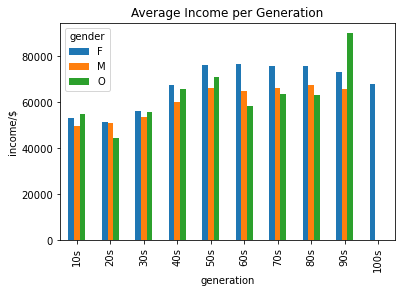

In [15]:
profile.pivot_table('income', index ='generation', columns='gender', aggfunc='mean').plot(kind='bar');
plt.title('Average Income per Generation');
plt.ylabel('income/$');

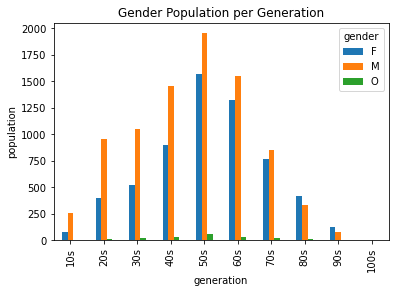

In [16]:
profile.pivot_table('income', index ='generation', columns='gender', aggfunc='count').plot(kind='bar');
plt.title('Gender Population per Generation');
plt.ylabel('population');

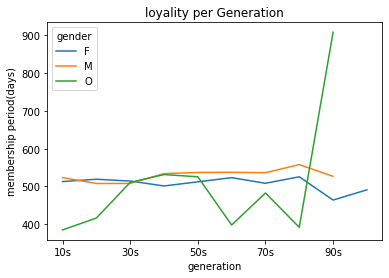

In [17]:
profile.pivot_table('loyality', index ='generation', columns='gender', aggfunc='mean').plot();
plt.title('loyality per Generation');
plt.ylabel('membership period(days)');

## 'transcript' dataframe

In [18]:
transcript.sample(20)

,person,event,value,time
56742,1b59e70b05e54356af6832ac10eba27e,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},168
92314,7f495962e50f40b1b76393c7c5343135,transaction,{'amount': 18.88},240
68393,44940fac0451459992c4fe4d6b1d1d08,transaction,{'amount': 20.78},168
102565,44247056e17d4ae38a1fdf92202b38de,transaction,{'amount': 17.92},282
175065,6c2c85ad5b244122a70425e6be34e0fd,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},426
200972,793cd4827125468498cb9050fad17882,transaction,{'amount': 9.97},498
8585,a182165ed3da4048917d042f7df9ae17,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
259500,b5e9fecfd7ff497cb3003b74277f9e5a,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},576
51769,ec462328d3cd4bf4bc72d7308750c4a8,transaction,{'amount': 19.72},156
209885,f3cae55a835f4c93aa70f0218c5ca13a,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},504


In [19]:
transcript = transcript.copy()

In [20]:
transcript.sample(50)

,person,event,value,time
207925,d643a3df453d42f4a5790a1ffb15b488,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504
82738,41c5f4d2e62b47058a65cdeddede89dd,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,204
202487,65daaf0f413744789903a355d6370b9d,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},504
216888,5eb8f0103c2b46d88e96be8beecbb6ef,transaction,{'amount': 10.94},504
34090,319abe74a62949209cb8a5531f89b3fd,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},66
42026,e4052622e5ba45a8b96b59aba68cf068,transaction,{'amount': 21.53},96
133453,02a3aa431c1047be8eafec3dcd6b5fd0,transaction,{'amount': 25.42},354
77190,4342cb3414534aaca96ac523edc82654,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},186
75204,42de30f65a554db2b2928ab318de7390,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},186
170517,93d9f674445142f5b5bf52193c19624b,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},414


In [21]:
dummy = pd.get_dummies(transcript['event'])
transcript =transcript.join(dummy)

In [22]:
transcript.sample(50)

,person,event,value,time,offer completed,offer received,offer viewed,transaction
268050,ef8f68ebd37f4560ae141cb13317ef06,transaction,{'amount': 7.72},588,0,0,0,1
192285,04e4f53f9be74c09a9751838010386e5,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,468,1,0,0,0
92736,5589f5c4d6164cb4bd1feaca5384315e,transaction,{'amount': 24.37},240,0,0,0,1
170996,a865d6d2d4814dc7a62046100031fb92,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},414,0,0,1,0
177244,2ce987015ec0404a97ba333e8e814090,transaction,{'amount': 3.34},426,0,0,0,1
217578,b25250db635840a994a37dc1d7e7ab59,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},504,0,0,1,0
8940,4e07135858ca4eaf829cc6e74b010016,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0,1,0,0
182652,2f19dfa70eef432380ec50165be2f884,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,444,1,0,0,0
220682,2ec52ca9f97f4feb9b5790ee4e0bce8c,transaction,{'amount': 13.14},510,0,0,0,1
51968,3124144d8d414799aa9a384fb62be3f3,transaction,{'amount': 8.27},156,0,0,0,1


In [23]:
transcript.person.nunique()

17000

In [24]:
#transcript['time'] = transcript['time'].apply(lambda x: pd.to_datetime(x), format='%H')
transcript['time'] = pd.to_datetime(transcript['time'])
#transcript['time'] = transcript['time'].astype('datetime64[ns]', format='%H')

In [25]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   person           306534 non-null  object        
 1   event            306534 non-null  object        
 2   value            306534 non-null  object        
 3   time             306534 non-null  datetime64[ns]
 4   offer completed  306534 non-null  uint8         
 5   offer received   306534 non-null  uint8         
 6   offer viewed     306534 non-null  uint8         
 7   transaction      306534 non-null  uint8         
dtypes: datetime64[ns](1), object(3), uint8(4)
memory usage: 10.5+ MB


In [26]:
transcript.value.sample(30)

226178                                    {'amount': 25.48}
110851     {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
38882      {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
72062                                     {'amount': 14.85}
254661     {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
105764                                    {'amount': 11.74}
243984                                    {'amount': 26.73}
251233     {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
172649     {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
57800      {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
224871                                    {'amount': 29.98}
227503                                     {'amount': 0.91}
81716                                     {'amount': 12.54}
250434     {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
151503     {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
61931      {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
215977     {'offer id': '5a8bc65990b245e

In [27]:
# waht is 'user_id'
transcript.query('index=="35749"')

,person,event,value,time,offer completed,offer received,offer viewed,transaction
35749,ea5f76f81dc8488a955172fb91d06bca,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,1970-01-01 00:00:00.000000072,1,0,0,0


In [28]:
# difference 'user id' and 'user_id'
transcript.query('index=="35749"')['value'].item()

{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}

> 'offer_id' is a reward given for completing an offer

In [29]:
transcript = pd.concat([transcript, pd.DataFrame(transcript.value.tolist())], axis=1)
transcript

,person,event,value,time,offer completed,offer received,offer viewed,transaction,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1970-01-01 00:00:00.000000000,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},1970-01-01 00:00:00.000000000,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},1970-01-01 00:00:00.000000000,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},1970-01-01 00:00:00.000000000,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1970-01-01 00:00:00.000000000,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},1970-01-01 00:00:00.000000714,0,0,0,1,NaN,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},1970-01-01 00:00:00.000000714,0,0,0,1,NaN,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},1970-01-01 00:00:00.000000714,0,0,0,1,NaN,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},1970-01-01 00:00:00.000000714,0,0,0,1,NaN,3.53,NaN,NaN


In [30]:
transcript['offer']= np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

In [31]:
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

In [32]:
transcript.rename(columns={'offer':'offer id'},inplace=True)
transcript

,person,event,value,time,offer completed,offer received,offer viewed,transaction,amount,reward,offer id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1970-01-01 00:00:00.000000000,0,1,0,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},1970-01-01 00:00:00.000000000,0,1,0,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},1970-01-01 00:00:00.000000000,0,1,0,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},1970-01-01 00:00:00.000000000,0,1,0,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1970-01-01 00:00:00.000000000,0,1,0,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},1970-01-01 00:00:00.000000714,0,0,0,1,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},1970-01-01 00:00:00.000000714,0,0,0,1,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},1970-01-01 00:00:00.000000714,0,0,0,1,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},1970-01-01 00:00:00.000000714,0,0,0,1,3.53,NaN,NaN


In [33]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   person           306534 non-null  object        
 1   event            306534 non-null  object        
 2   value            306534 non-null  object        
 3   time             306534 non-null  datetime64[ns]
 4   offer completed  306534 non-null  uint8         
 5   offer received   306534 non-null  uint8         
 6   offer viewed     306534 non-null  uint8         
 7   transaction      306534 non-null  uint8         
 8   amount           138953 non-null  float64       
 9   reward           33579 non-null   float64       
 10  offer id         167581 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(4), uint8(4)
memory usage: 17.5+ MB


In [34]:
transcript.amount.describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

C:\Users\wythe\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


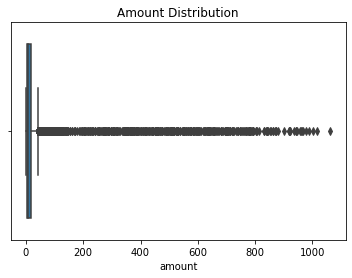

In [35]:
sb.boxplot(transcript.amount);
plt.title('Amount Distribution');

C:\Users\wythe\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


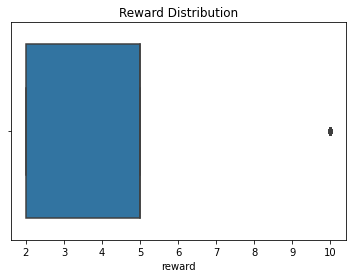

In [36]:
sb.boxplot(transcript.reward);
plt.title('Reward Distribution');

In [37]:
transcript.groupby(['event']).count()['value']

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: value, dtype: int64

## 3. Merge transcript + profile

In [38]:
profile.rename(columns={'id':'person'}, inplace=True)
profile.head(1)

C:\Users\wythe\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,gender,age,person,became_member_on,income,generation,loyality
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,50s,376


In [39]:
df = pd.merge(transcript, profile, on='person')
df

,person,event,value,time,offer completed,offer received,offer viewed,transaction,amount,reward,offer id,gender,age,became_member_on,income,generation,loyality
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1970-01-01 00:00:00.000000000,0,1,0,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,70s,443
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1970-01-01 00:00:00.000000006,0,0,1,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,70s,443
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},1970-01-01 00:00:00.000000132,0,0,0,1,19.89,NaN,NaN,F,75,2017-05-09,100000.0,70s,443
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,1970-01-01 00:00:00.000000132,1,0,0,0,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,70s,443
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},1970-01-01 00:00:00.000000144,0,0,0,1,17.78,NaN,NaN,F,75,2017-05-09,100000.0,70s,443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},1970-01-01 00:00:00.000000504,0,0,1,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,47,2017-10-13,94000.0,40s,286
272758,9fcbff4f8d7241faa4ab8a9d19c8a812,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1970-01-01 00:00:00.000000576,0,1,0,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,M,47,2017-10-13,94000.0,40s,286
272759,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1970-01-01 00:00:00.000000576,0,0,1,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,M,47,2017-10-13,94000.0,40s,286
272760,3045af4e98794a04a5542d3eac939b1f,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1970-01-01 00:00:00.000000576,0,1,0,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,F,58,2016-10-20,78000.0,50s,644


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   person            272762 non-null  object        
 1   event             272762 non-null  object        
 2   value             272762 non-null  object        
 3   time              272762 non-null  datetime64[ns]
 4   offer completed   272762 non-null  uint8         
 5   offer received    272762 non-null  uint8         
 6   offer viewed      272762 non-null  uint8         
 7   transaction       272762 non-null  uint8         
 8   amount            123957 non-null  float64       
 9   reward            32444 non-null   float64       
 10  offer id          148805 non-null  object        
 11  gender            272762 non-null  object        
 12  age               272762 non-null  int64         
 13  became_member_on  272762 non-null  datetime64[ns]
 14  inco

## 4. Creation of df_full for exploration

In [41]:
df_full = pd.merge(df, portfolio, how='outer',on='offer id')

In [42]:
df_full.head()

,person,event,value,time,offer completed,offer received,offer viewed,transaction,amount,reward_x,...,age,became_member_on,income,generation,loyality,reward_y,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1970-01-01 00:00:00.000000000,0,1,0,0,NaN,NaN,...,75,2017-05-09,100000.0,70s,443,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1970-01-01 00:00:00.000000006,0,0,1,0,NaN,NaN,...,75,2017-05-09,100000.0,70s,443,5.0,"[web, email, mobile]",5.0,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,1970-01-01 00:00:00.000000132,1,0,0,0,NaN,5.0,...,75,2017-05-09,100000.0,70s,443,5.0,"[web, email, mobile]",5.0,7.0,bogo
3,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1970-01-01 00:00:00.000000408,0,1,0,0,NaN,NaN,...,68,2018-04-26,70000.0,60s,91,5.0,"[web, email, mobile]",5.0,7.0,bogo
4,e2127556f4f64592b11af22de27a7932,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1970-01-01 00:00:00.000000420,0,0,1,0,NaN,NaN,...,68,2018-04-26,70000.0,60s,91,5.0,"[web, email, mobile]",5.0,7.0,bogo


In [43]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   person            272762 non-null  object        
 1   event             272762 non-null  object        
 2   value             272762 non-null  object        
 3   time              272762 non-null  datetime64[ns]
 4   offer completed   272762 non-null  uint8         
 5   offer received    272762 non-null  uint8         
 6   offer viewed      272762 non-null  uint8         
 7   transaction       272762 non-null  uint8         
 8   amount            123957 non-null  float64       
 9   reward_x          32444 non-null   float64       
 10  offer id          148805 non-null  object        
 11  gender            272762 non-null  object        
 12  age               272762 non-null  int64         
 13  became_member_on  272762 non-null  datetime64[ns]
 14  inco

In [44]:
df_full.to_csv('df_full.csv', index=False)

# 5. Exploration

In [45]:
df_full = pd.read_csv('df_full.csv')
df_full.head()

C:\Users\wythe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10,18,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,person,event,value,time,offer completed,offer received,offer viewed,transaction,amount,reward_x,...,age,became_member_on,income,generation,loyality,reward_y,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1970-01-01 00:00:00.000000000,0,1,0,0,NaN,NaN,...,75,2017-05-09 00:00:00.000000000,100000.0,70s,443,5.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1970-01-01 00:00:00.000000006,0,0,1,0,NaN,NaN,...,75,2017-05-09 00:00:00.000000000,100000.0,70s,443,5.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,1970-01-01 00:00:00.000000132,1,0,0,0,NaN,5.0,...,75,2017-05-09 00:00:00.000000000,100000.0,70s,443,5.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
3,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1970-01-01 00:00:00.000000408,0,1,0,0,NaN,NaN,...,68,2018-04-26 00:00:00.000000000,70000.0,60s,91,5.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
4,e2127556f4f64592b11af22de27a7932,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1970-01-01 00:00:00.000000420,0,0,1,0,NaN,NaN,...,68,2018-04-26 00:00:00.000000000,70000.0,60s,91,5.0,"['web', 'email', 'mobile']",5.0,7.0,bogo


In [46]:
df_full.amount.describe()

count    123957.000000
mean         13.996325
std          31.749420
min           0.050000
25%           3.660000
50%          10.800000
75%          19.130000
max        1062.280000
Name: amount, dtype: float64

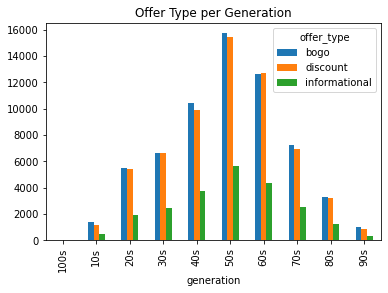

In [47]:
df_full.pivot_table('person', index='generation', columns='offer_type', aggfunc='count').plot(kind='bar');
plt.title('Offer Type per Generation');

In [48]:
df_full.pivot_table('offer viewed', index='generation', columns='offer_type', aggfunc='sum', margins=True)

offer_type,bogo,discount,informational,All
generation,,,,
100s,2,9,5,16
10s,521,330,211,1062
20s,1985,1520,758,4263
30s,2339,1951,996,5286
40s,3691,3056,1597,8344
50s,5305,4552,2340,12197
60s,4289,3798,1778,9865
70s,2443,2035,1036,5514
80s,1126,951,513,2590


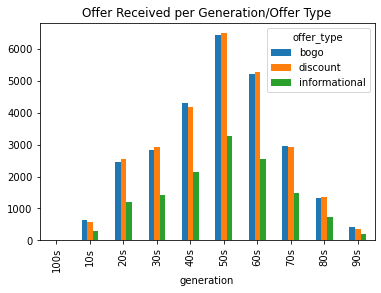

In [64]:
df_full.pivot_table('offer received', index='generation', columns='offer_type', aggfunc='sum').plot(kind='bar');
plt.title('Offer Received per Generation/Offer Type');

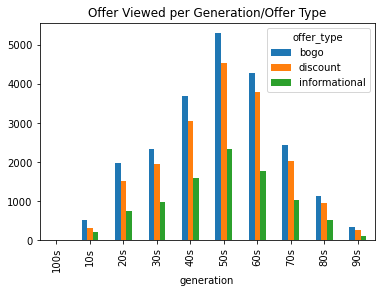

In [65]:
df_full.pivot_table('offer viewed', index='generation', columns='offer_type', aggfunc='sum').plot(kind='bar');
plt.title('Offer Viewed per Generation/Offer Type');

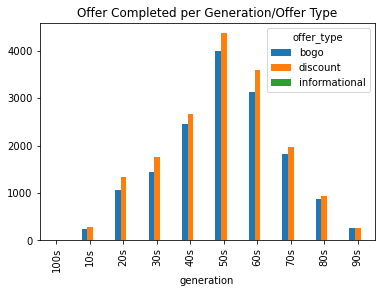

In [66]:
df_full.pivot_table('offer completed', index='generation', columns='offer_type', aggfunc='sum').plot(kind='bar');
plt.title('Offer Completed per Generation/Offer Type');

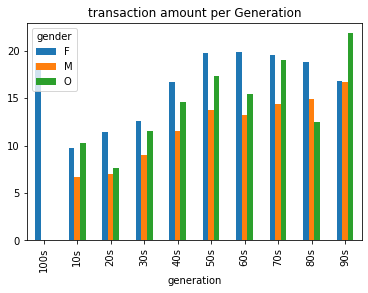

In [52]:
df_full.pivot_table('amount', index='generation', columns='gender', aggfunc='mean').plot(kind='bar');
plt.title('transaction amount per Generation');

In [53]:
def best_customer(df_full=df_full,n=15):
    
    '''
    input: df_full, n(rank)
    output: gende, age, income
    '''
    rank = df_full.groupby(['person', 'age','gender','loyality','income']).sum()['amount'].sort_values(ascending=False)[:n]
    
    return rank

best_customer()    

person                            age  gender  loyality  income  
3c8d541112a74af99e88abbd0692f00e  77   M       303       97000.0     1608.69
f1d65ae63f174b8f80fa063adcaa63b7  32   M       37        64000.0     1365.66
ae6f43089b674728a50b8727252d3305  36   F       431       71000.0     1327.74
626df8678e2a4953b9098246418c9cfa  53   M       1066      103000.0    1321.42
73afdeca19e349b98f09e928644610f8  50   M       805       86000.0     1319.97
52959f19113e4241a8cb3bef486c6412  55   M       583       111000.0    1292.86
ad1f0a409ae642bc9a43f31f56c130fc  66   M       333       80000.0     1258.19
d240308de0ee4cf8bb6072816268582b  43   F       391       94000.0     1251.99
946fc0d3ecc4492aa4cc06cf6b1492c3  58   M       417       79000.0     1232.40
6406abad8e2c4b8584e4f68003de148d  67   M       879       79000.0     1211.76
6cf884a6c5ae4b2daccb6d3108028fef  58   F       1085      110000.0    1165.26
8c6b2a81cb294c28b740e9c459ab7767  58   F       428       97000.0     1154.75
5ecaea5c8b

## Creation offer_complete df

In [54]:
received = df_full['offer received'].sum()
received

66501

In [55]:
offerid = list(portfolio['offer id'])
offerid

['ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '3f207df678b143eea3cee63160fa8bed',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'fafdcd668e3743c1bb461111dcafc2a4',
 '5a8bc65990b245e5a138643cd4eb9837',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '2906b810c7d4411798c6938adc9daaa5']

In [56]:
offer = df_full.groupby(['offer id','offer_type']).sum()[['offer received', 'offer viewed','offer completed']]
pd.DataFrame(offer)

,,offer received,offer viewed,offer completed
offer id,offer_type,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,6726,2215,3386
2298d6c36e964ae4a3e7e9706d1fb8c2,discount,6655,6379,4886
2906b810c7d4411798c6938adc9daaa5,discount,6631,3460,3911
3f207df678b143eea3cee63160fa8bed,informational,6657,3487,0
4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,6593,6329,3310
5a8bc65990b245e5a138643cd4eb9837,informational,6643,5873,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,6685,3499,4188
ae264e3637204a6fb9bb56bc8210ddfd,bogo,6683,5901,3657
f19421c1d4aa40978ebb69ca19b0e20d,bogo,6576,6310,4103


In [57]:
offer_1 = df_full.groupby(['offer id']).sum()[['offer received','offer viewed','offer completed']]
pd.DataFrame(offer_1)

,offer received,offer viewed,offer completed
offer id,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,2215,3386
2298d6c36e964ae4a3e7e9706d1fb8c2,6655,6379,4886
2906b810c7d4411798c6938adc9daaa5,6631,3460,3911
3f207df678b143eea3cee63160fa8bed,6657,3487,0
4d5c57ea9a6940dd891ad53e9dbe8da0,6593,6329,3310
5a8bc65990b245e5a138643cd4eb9837,6643,5873,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,3499,4188
ae264e3637204a6fb9bb56bc8210ddfd,6683,5901,3657
f19421c1d4aa40978ebb69ca19b0e20d,6576,6310,4103


In [58]:
offer_1 = df_full.groupby(['offer id']).sum()['offer completed']
offer_1

offer id
0b1e1539f2cc45b7b9fa7c272da2e1d7    3386
2298d6c36e964ae4a3e7e9706d1fb8c2    4886
2906b810c7d4411798c6938adc9daaa5    3911
3f207df678b143eea3cee63160fa8bed       0
4d5c57ea9a6940dd891ad53e9dbe8da0    3310
5a8bc65990b245e5a138643cd4eb9837       0
9b98b8c7a33c4b65b9aebfe6a799e6d9    4188
ae264e3637204a6fb9bb56bc8210ddfd    3657
f19421c1d4aa40978ebb69ca19b0e20d    4103
fafdcd668e3743c1bb461111dcafc2a4    5003
Name: offer completed, dtype: int64

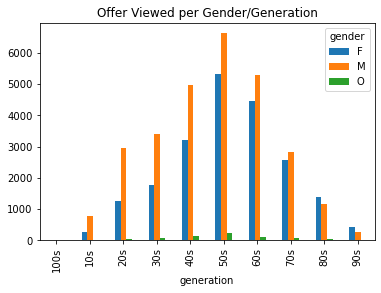

In [59]:
df_full.pivot_table('offer viewed', index='generation', columns='gender', aggfunc='sum').plot(kind='bar');
plt.title('Offer Viewed per Gender/Generation');

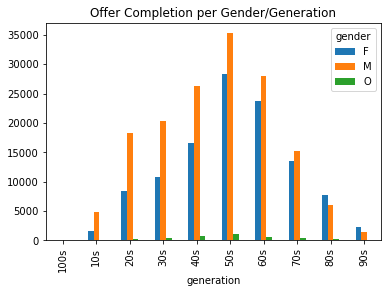

In [60]:
df_full.pivot_table('offer completed', index='generation', columns='gender', aggfunc='count').plot(kind='bar');
plt.title('Offer Completion per Gender/Generation');

> **Finding 1**: Female of older than 50s tend to complete offer given the numbers of received and reviewed.

> **Finding 2**: Others shows little interest in offer completion for all generation.

In [61]:
df_full.groupby('offer_type').count()['offer completed']

offer_type
bogo             63834
discount         62311
informational    22660
Name: offer completed, dtype: int64

In [62]:
df_full.pivot_table(index=['person','event','gender','offer_type'])

age  \
person                           event           gender offer_type           
0009655768c64bdeb2e877511632db8f offer completed M      bogo            33   
                                                        discount        33   
                                 offer received  M      bogo            33   
                                                        discount        33   
                                                        informational   33   
...                                                                    ...   
ffff82501cea40309d5fdd7edcca4a07 offer completed F      discount        45   
                                 offer received  F      bogo            45   
                                                        discount        45   
                                 offer viewed    F      bogo            45   
                                                        discount        45   

                                                                       difficulty  \
person                           event           gender offer_type                  
0009655768c64bdeb2e877511632db8f offer completed M      bogo                  5.0   
                                                        discount             10.0   
                                 offer received  M      bogo                  5.0   
                                                        discount             10.0   
                                                        informational         0.0   
...                                                                           ...   
ffff82501cea40309d5fdd7edcca4a07 offer completed F      discount             12.0   
                                 offer received  F      bogo                  5.0   
                                                        discount             12.0   
                                 offer viewed    F      bogo                  5.0   
                                                        discount             12.0   

                                                                       duration  \
person                           event           gender offer_type                
0009655768c64bdeb2e877511632db8f offer completed M      bogo                5.0   
                                                        discount            8.5   
                                 offer received  M      bogo                5.0   
                                                        discount            8.5   
                                                        informational       3.5   
...                                                                         ...   
ffff82501cea40309d5fdd7edcca4a07 offer completed F      discount            8.2   
                                 offer received  F      bogo                7.0   
                                                        discount            8.2   
                                 offer viewed    F      bogo                7.0   
                                                        discount            8.2   

                                                                        income  \
person                           event           gender offer_type               
0009655768c64bdeb2e877511632db8f offer completed M      bogo           72000.0   
                                                        discount       72000.0   
                                 offer received  M      bogo           72000.0   
                                                        discount       72000.0   
                                                        informational  72000.0   
...                                                                        ...   
ffff82501cea40309d5fdd7edcca4a07 offer completed F      discount       62000.0   
                                 offer received  F      bogo           62000.0   
                                                  

In [63]:
df_full.pivot_table(index=['person','event','gender','offer_type'], aggfunc=len, margins=True)

age  \
person                           event           gender offer_type           
0009655768c64bdeb2e877511632db8f offer completed M      bogo             1   
                                                        discount         2   
                                 offer received  M      bogo             1   
                                                        discount         2   
                                                        informational    2   
...                                                                    ...   
ffff82501cea40309d5fdd7edcca4a07 offer received  F      bogo             1   
                                                        discount         5   
                                 offer viewed    F      bogo             1   
                                                        discount         5   
All                                                                      0   

                                                                       amount  \
person                           event           gender offer_type              
0009655768c64bdeb2e877511632db8f offer completed M      bogo              1.0   
                                                        discount          2.0   
                                 offer received  M      bogo              1.0   
                                                        discount          2.0   
                                                        informational     2.0   
...                                                                       ...   
ffff82501cea40309d5fdd7edcca4a07 offer received  F      bogo              1.0   
                                                        discount          5.0   
                                 offer viewed    F      bogo              1.0   
                                                        discount          5.0   
All                                                                       0.0   

                                                                       became_member_on  \
person                           event           gender offer_type                        
0009655768c64bdeb2e877511632db8f offer completed M      bogo                          1   
                                                        discount                      2   
                                 offer received  M      bogo                          1   
                                                        discount                      2   
                                                        informational                 2   
...                                                                                 ...   
ffff82501cea40309d5fdd7edcca4a07 offer received  F      bogo                          1   
                                                        discount                      5   
                                 offer viewed    F      bogo                          1   
                                                        discount                      5   
All                                                                                   0   

                                                                       channels  \
person                           event           gender offer_type                
0009655768c64bdeb2e877511632db8f offer completed M      bogo                  1   
                                                        discount              2   
                                 offer received  M      bogo                  1   
                                                        discount              2   
                                                        informational         2   
...                                                                         ...   
ffff82501cea40309d5fdd7edcca4a07 offer received  F      bogo                  1   
                                                        discount       